In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from collections import Counter
from matplotlib.lines import Line2D

In [65]:
from networkx.drawing.nx_agraph import to_agraph
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [5]:
!apt install libgraphviz-dev
!pip install pygraphviz

zsh:1: command not found: apt
  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [100 lines of output]
      /private/var/folders/hz/6gc0ty210759pz21t71k8wk80000gn/T/pip-build-env-f_y3l_2d/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove depr

# **Pre-processing**

In [3]:
# get all data
df = pd.read_csv('https://raw.githubusercontent.com/Justin-Pascua/MATH-168-Group-Project/refs/heads/main/full_opensecrets_data.csv')

# filter down to top x-donors, where 0 <= x <= 100
x = 50
df = df.groupby('Senator').head(x).reset_index()
df

,index,Senator,Party,Organization,Total,PACs,Individuals
0,0,"Baldwin, Tammy",(D),University of Wisconsin,528258,0,528258
1,1,"Baldwin, Tammy",(D),JStreetPAC,216748,9706,207042
2,2,"Baldwin, Tammy",(D),Democracy Engine,187684,0,187684
3,3,"Baldwin, Tammy",(D),League of Conservation Voters,97896,12213,85683
4,4,"Baldwin, Tammy",(D),State of Wisconsin,91576,0,91576
...,...,...,...,...,...,...,...
4995,9945,"Young, Todd",(R),Marathon Petroleum,36025,36000,25
4996,9946,"Young, Todd",(R),Massachusetts Mutual Life Insurance,35525,25000,10525
4997,9947,"Young, Todd",(R),ANGI Homeservices,35400,0,35400
4998,9948,"Young, Todd",(R),American Senior Communities,35200,0,35200


In [5]:
pivot_df = df.pivot_table(index='Senator', columns='Organization', values='Total', aggfunc='sum', fill_value=0)

In [7]:
normalized_data = normalize(pivot_df, norm='l2')

In [15]:
linked = linkage(normalized_data, method='ward')

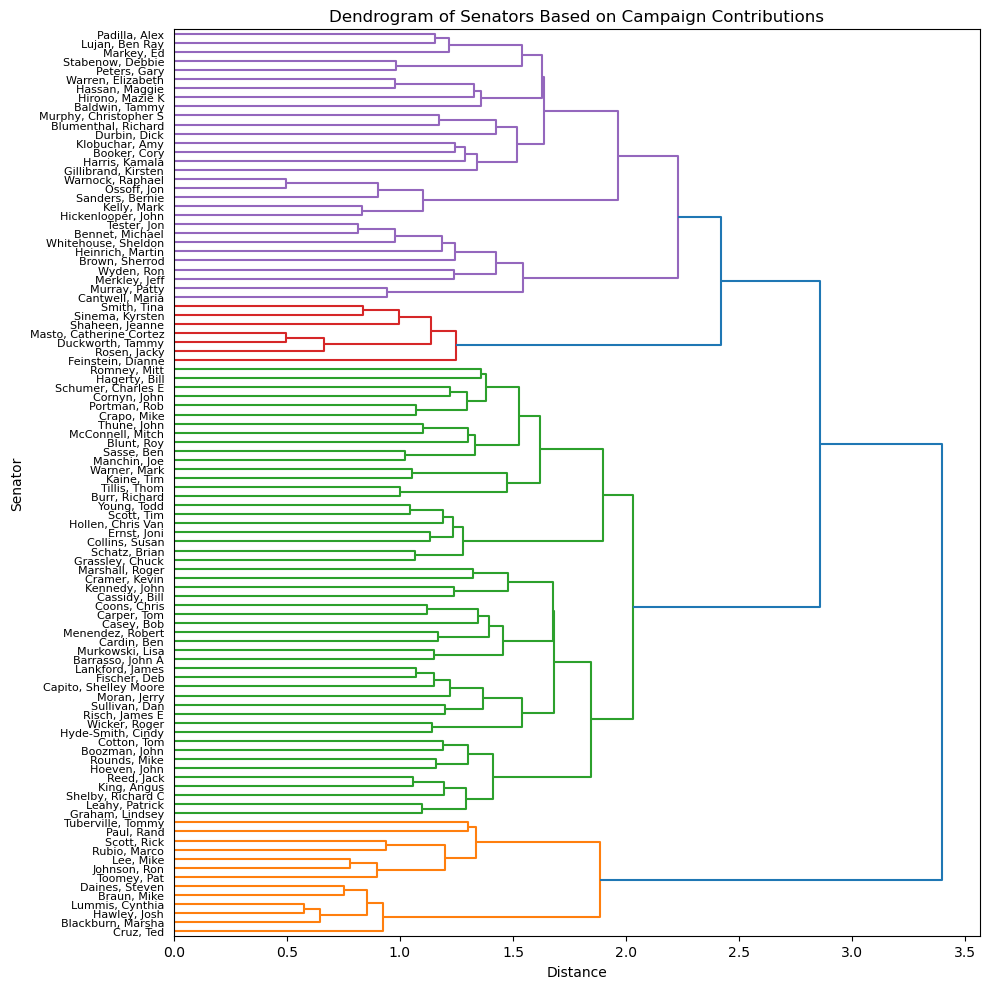

In [57]:
#Plot the dendrogram
plt.figure(figsize=(10, 10))
dendrogram(linked, labels=pivot_df.index.tolist(), orientation='right', leaf_font_size=8)
plt.title('Dendrogram of Senators Based on Campaign Contributions')
plt.xlabel('Distance')
plt.ylabel('Senator')
plt.tight_layout()
plt.show()

In [9]:
# compute normalized contributions (i.e. normalize donation amounts so that weighted degree of each senator is 1)

# initialize normalized columns
df['Portion of Total'] = 0.0
df['Portion of PACs'] = 0.0
df['Portion of Individuals'] = 0.0

# get unique names
senators = df['Senator'].unique()

for senator in senators:
  # get entries corresponding to fixed senator
  temp_df = df[df['Senator'] == senator].copy()

  # compute totals for PACs, Individuals, and Total column
  pacs_total = temp_df['PACs'].sum()
  individuals_total = temp_df['Individuals'].sum()
  combined_total = pacs_total + individuals_total

  # divide each entry with corresponding total
  df.loc[df['Senator'] == senator, 'Portion of Total'] = temp_df['Total']/combined_total
  df.loc[df['Senator'] == senator, 'Portion of PACs'] = temp_df['Individuals']/individuals_total
  df.loc[df['Senator'] == senator, 'Portion of Individuals'] = temp_df['PACs']/pacs_total

df

,index,Senator,Party,Organization,Total,PACs,Individuals,Portion of Total,Portion of PACs,Portion of Individuals
0,0,"Baldwin, Tammy",(D),University of Wisconsin,528258,0,528258,0.181997,0.247171,0.000000
1,1,"Baldwin, Tammy",(D),JStreetPAC,216748,9706,207042,0.074675,0.096875,0.012682
2,2,"Baldwin, Tammy",(D),Democracy Engine,187684,0,187684,0.064662,0.087817,0.000000
3,3,"Baldwin, Tammy",(D),League of Conservation Voters,97896,12213,85683,0.033727,0.040091,0.015958
4,4,"Baldwin, Tammy",(D),State of Wisconsin,91576,0,91576,0.031550,0.042848,0.000000
...,...,...,...,...,...,...,...,...,...,...
4995,9945,"Young, Todd",(R),Marathon Petroleum,36025,36000,25,0.012870,0.000011,0.074257
4996,9946,"Young, Todd",(R),Massachusetts Mutual Life Insurance,35525,25000,10525,0.012692,0.004548,0.051568
4997,9947,"Young, Todd",(R),ANGI Homeservices,35400,0,35400,0.012647,0.015296,0.000000
4998,9948,"Young, Todd",(R),American Senior Communities,35200,0,35200,0.012576,0.015210,0.000000


# **Graph Construction**

Here, the edge between a donor and a politician in the bipartite graph is weighted by the fraction of the total campaign funds that the donor accounts for. For example, if a donor contributed \$1,000 to a politician, and that politician has a total of \$20,000 in campaign funds from all donors, then the corresponding edge would have weight 1/20

In [11]:
def construct_network(weight_by = 'Portion of Total'):
  # initialize graph
  bip_graph = nx.Graph()

  # add nodes for donors
  bip_graph.add_nodes_from(df['Organization'], bipartite = 0)

  # add nodes for senators
  bip_graph.add_nodes_from(df['Senator'], bipartite = 1)

  # get edges from df, weighted by normalized contributions
  edges = [(df['Organization'][i], df['Senator'][i], {'weight': df[weight_by][i]}) for i in range(len(df))]

  # add edges to graph
  bip_graph.add_edges_from(edges)

  row_nodes = list(df['Organization'].unique())
  col_nodes = list(df['Senator'].unique())

  # Get incidence matrix
  inc_matrix = nx.bipartite.biadjacency_matrix(bip_graph, row_nodes, col_nodes)

  # Get weighted adjacency matrices using incidence matrix
  senator_proj_matrix = inc_matrix.T @ inc_matrix
  donor_proj_matrix = inc_matrix @ inc_matrix.T

  # Convert into arrays
  senator_proj_matrix = senator_proj_matrix.toarray()
  donor_proj_matrix = donor_proj_matrix.toarray()

  # Create projections using adjacency matrices
  senator_network = nx.from_numpy_array(senator_proj_matrix)
  donor_network = nx.from_numpy_array(donor_proj_matrix)

  # Add weighted degree to attributes of each node
  for i in range(100):
    senator_network.nodes[i]['Weighted Degree'] = senator_proj_matrix[i].sum()

  for i in donor_network.nodes:
    donor_network.nodes[i]['Weighted Degree'] = donor_proj_matrix[i].sum()

  return bip_graph, senator_proj_matrix, donor_proj_matrix, senator_network, donor_network

In [37]:
bip_graph, senator_proj_matrix, donor_proj_matrix, senator_network, donor_network = construct_network()

# **Identifying Edges of Highest Weight**

Below, we list the edges (and the corresponding pair of senators that are joined by that edge) sorted from highest weight to lowest

In [13]:
# List senator pairs from highest to lowest edge weight
edge_weights_df = pd.DataFrame(columns = ["Senator Pair", "Edge Weight"], index = range(4950))

# Iterate over all unordered pairs of senators
N = 0
for i in range(100):
  for j in range(i):
    # Record names of senators in pari
    edge_weights_df.iloc[N, 0] = f"{senators[i]} and {senators[j]}"
    try:
      # If edge exists, record weight
      edge_weights_df.iloc[N, 1] = senator_network.edges[(i,j)]['weight']
    except:
      # Otherwise, nothing
      pass
    N += 1

# Sort by weight
edge_weights_df.sort_values('Edge Weight', ascending = False, inplace = True)

# Drop any pairs not connected by an edge
edge_weights_df.dropna(inplace = True)

# Reset indices
edge_weights_df.reset_index(inplace = True, drop = True)

edge_weights_df

,Senator Pair,Edge Weight


In [14]:
# Finding common donors of Duckworth and Masto
duckworth_df = df[df['Senator'] == 'Duckworth, Tammy'].copy()
duckworth_donors = set(duckworth_df['Organization'])

masto_df = df[df['Senator'] == 'Masto, Catherine Cortez'].copy()
masto_donors = set(masto_df['Organization'])

common_donors = duckworth_donors & masto_donors
common_donors

{'Council for a Livable World',
 'Democratic Senatorial Campaign Cmte',
 "EMILY's List",
 'Honeywell International',
 'JStreetPAC',
 'League of Conservation Voters',
 'University of California'}

In [16]:
# Finding common donors of Sanders and Hagerty
sanders_df = df[df['Senator'] == 'Sanders, Bernie'].copy()
sanders_donors = set(sanders_df['Organization'])

hagerty_df = df[df['Senator'] == 'Hagerty, Bill'].copy()
hagerty_donors = set(hagerty_df['Organization'])

common_donors = sanders_donors & hagerty_donors
common_donors

set()

# **Visualizations of the bipartite network**

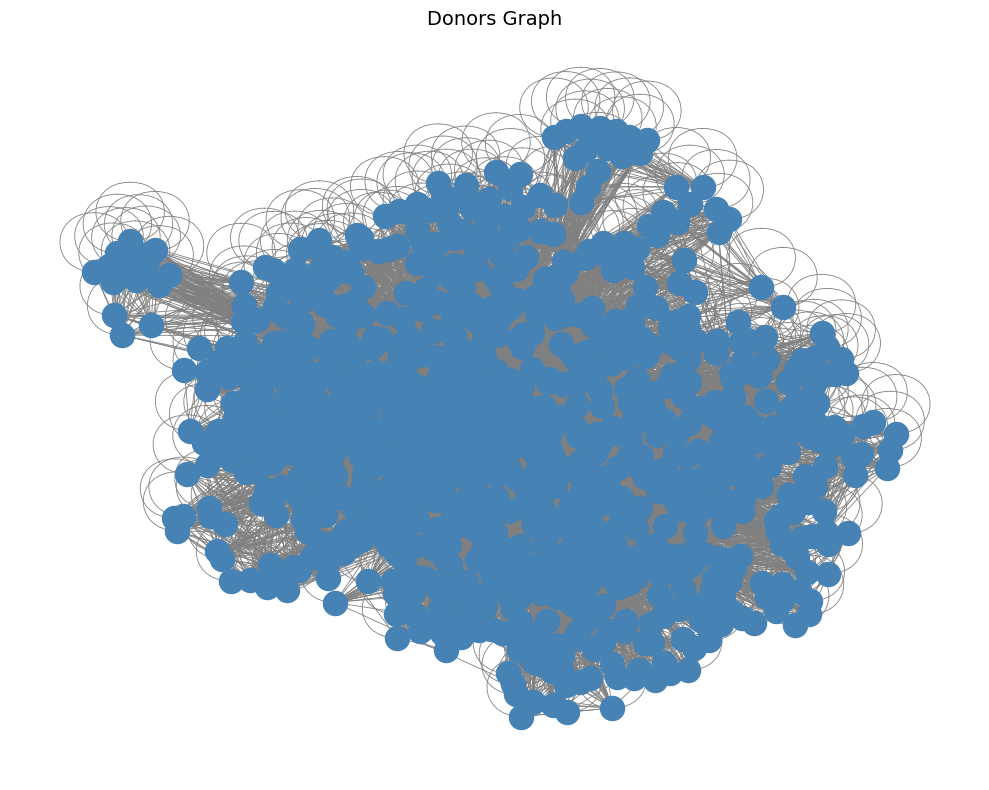

In [18]:
plt.figure(figsize=(10, 8))

# layout
pos = nx.spring_layout(donor_network, seed=1)

# draw nodes (blue circles)
nx.draw_networkx_nodes(donor_network, pos, node_color='steelblue', node_size=300)

# draw edges (thin grey lines)
nx.draw_networkx_edges(donor_network, pos, edge_color='grey', width=0.6)

# optional: senator names
#nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Donors Graph", fontsize=14)   # ← label for the whole graph
plt.axis('off')
plt.tight_layout()
plt.show()

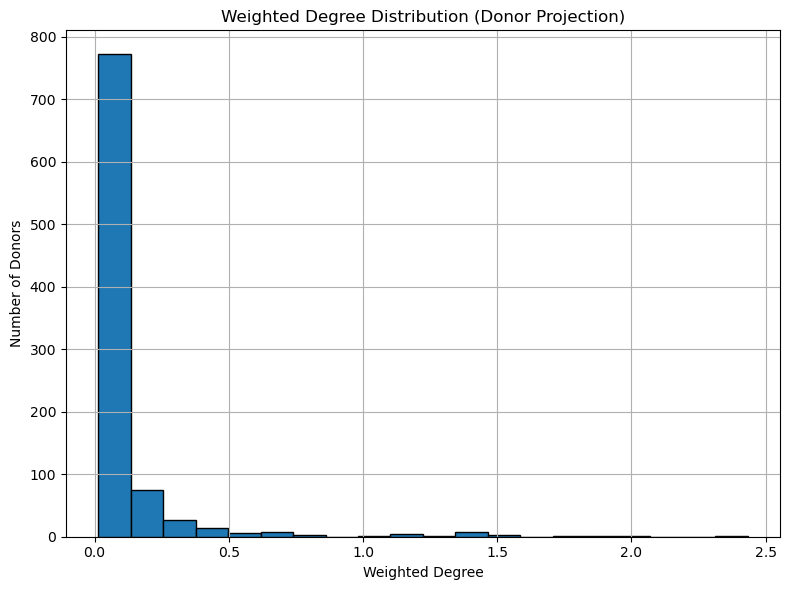

In [41]:
# Get weighted degrees
donor_weighted_degrees = [deg for _, deg in donor_network.degree(weight='weight')]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(donor_weighted_degrees, bins=20, edgecolor='black')
plt.xlabel("Weighted Degree")
plt.ylabel("Number of Donors")
plt.title("Weighted Degree Distribution (Donor Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

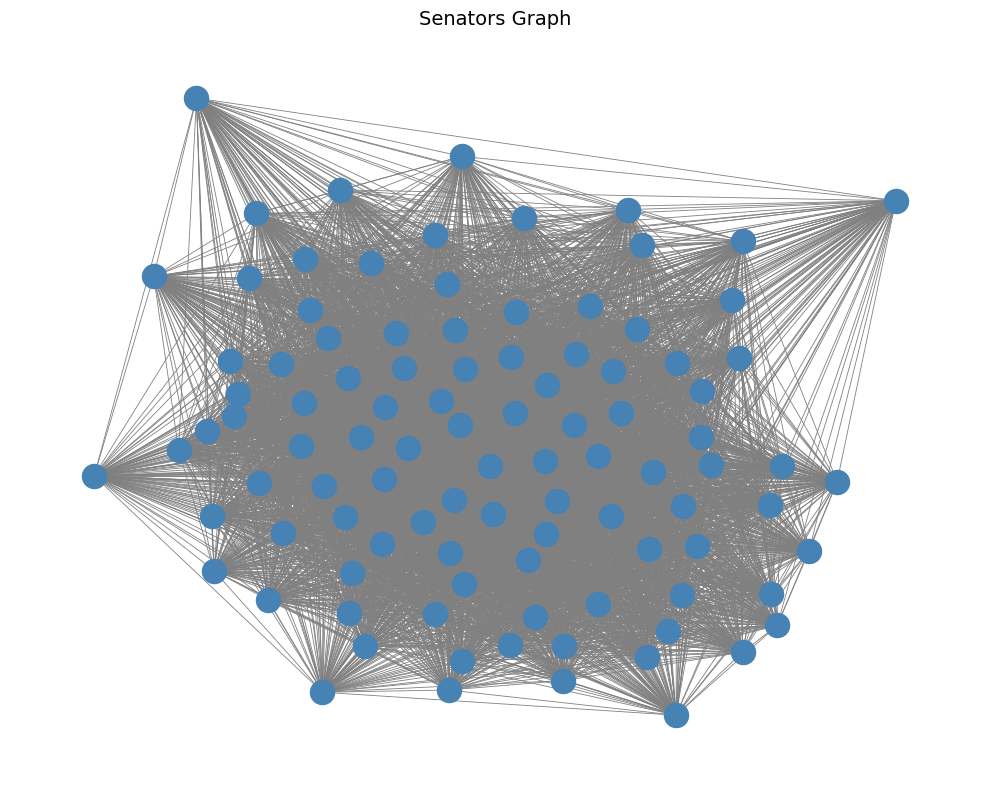

In [ ]:
plt.figure(figsize=(10, 8))

# layout
pos = nx.spring_layout(senator_network, seed=1)

# draw nodes (blue circles)
nx.draw_networkx_nodes(senator_network, pos, node_color='steelblue', node_size=300)

# draw edges (thin grey lines)
nx.draw_networkx_edges(senator_network, pos, edge_color='grey', width=0.6)

# optional: senator names
#nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Senators Graph", fontsize=14)   # ← label for the whole graph
plt.axis('off')
plt.tight_layout()
plt.show()

Degree Distribution of Senators Graph

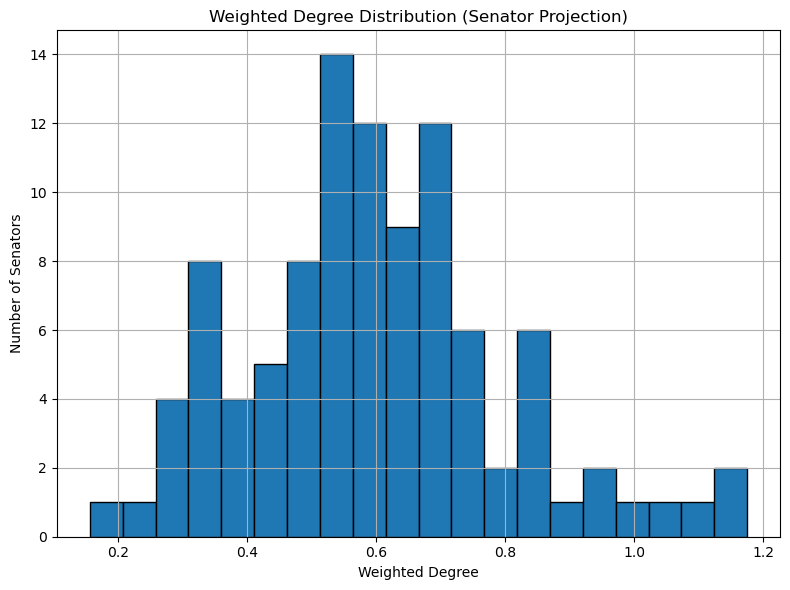

In [39]:
# Get weighted degrees
senator_weighted_degrees = [deg for _, deg in senator_network.degree(weight='weight')]

# Plot
plt.figure(figsize=(8, 6))
plt.hist(senator_weighted_degrees, bins=20, edgecolor='black')
plt.xlabel("Weighted Degree")
plt.ylabel("Number of Senators")
plt.title("Weighted Degree Distribution (Senator Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()

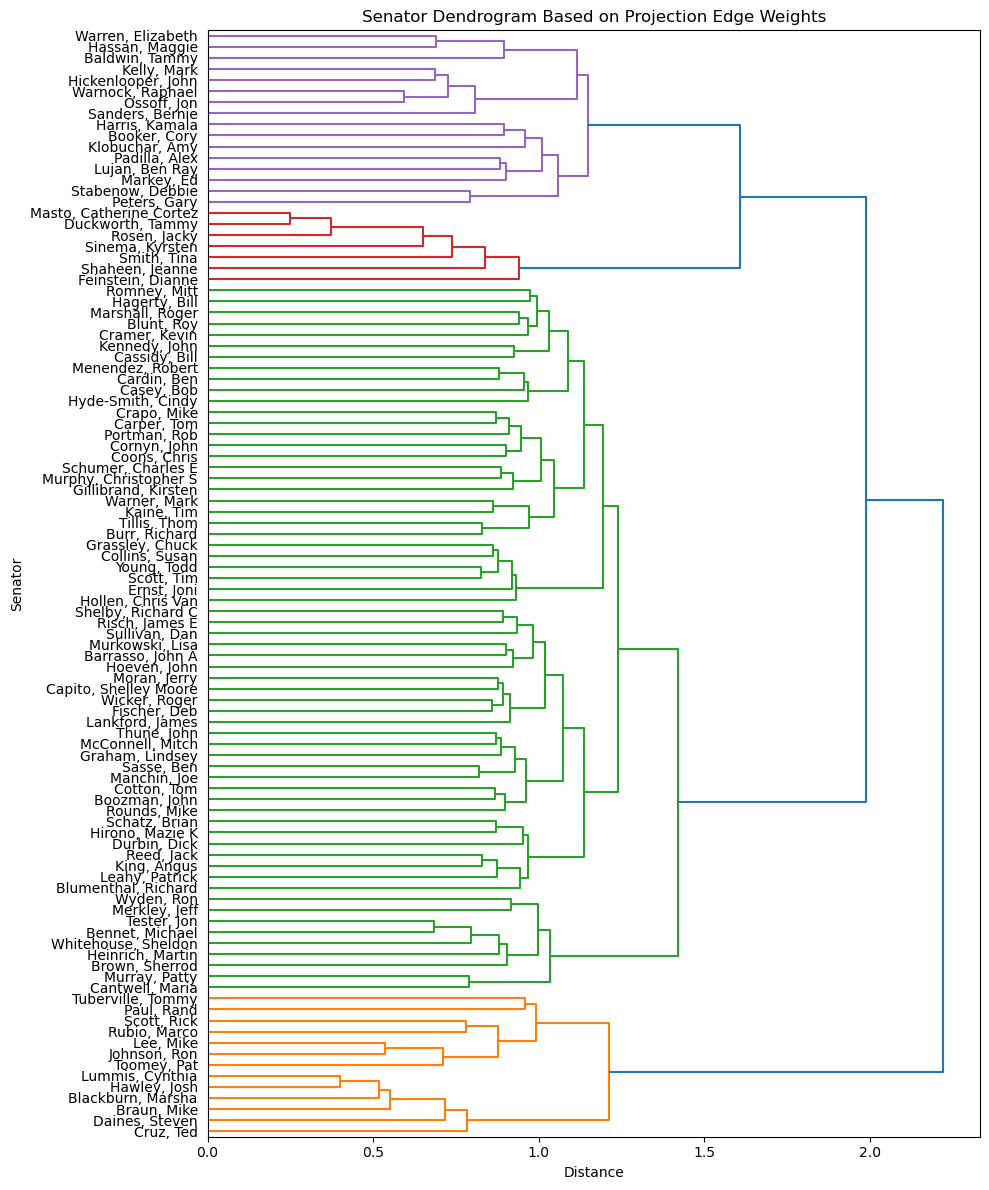

In [33]:
# Step 2: Normalize contributions
df['Portion of Total'] = 0.0
for senator in df['Senator'].unique():
    temp_df = df[df['Senator'] == senator]
    pacs_total = temp_df['PACs'].sum()
    individuals_total = temp_df['Individuals'].sum()
    total = pacs_total + individuals_total
    if total > 0:
        df.loc[df['Senator'] == senator, 'Portion of Total'] = temp_df['Total'] / total

# Step 3: Create a bipartite graph and compute senator projection
bip_graph = nx.Graph()
bip_graph.add_nodes_from(df['Organization'], bipartite=0)
bip_graph.add_nodes_from(df['Senator'], bipartite=1)

# Add weighted edges
edges = [(row['Organization'], row['Senator'], {'weight': row['Portion of Total']}) for _, row in df.iterrows()]
bip_graph.add_edges_from(edges)

row_nodes = df['Organization'].unique()
col_nodes = df['Senator'].unique()

# Incidence matrix and projection
inc_matrix = nx.bipartite.biadjacency_matrix(bip_graph, row_nodes, col_nodes, weight='weight')
proj_matrix = inc_matrix.T @ inc_matrix
proj_matrix = proj_matrix.toarray()

# Step 4: Build similarity matrix from edge weights
similarity_matrix = proj_matrix.copy()

# Step 5: Convert to distance matrix (normalize and invert)
max_sim = np.max(similarity_matrix)
distance_matrix = 1 - (similarity_matrix / max_sim)
np.fill_diagonal(distance_matrix, 0)  # ensure diagonal is zero
condensed_distance = squareform(distance_matrix)

# Step 6: Hierarchical clustering and dendrogram
linked = linkage(condensed_distance, method='ward')

# Number of clusters you want to identify
num_clusters = 4

# 1. Assign senators to clusters
flat_clusters = fcluster(linked_ward, num_clusters, criterion='maxclust')
senator_to_cluster = {name: cluster for name, cluster in zip(col_nodes, flat_clusters)}

# 2. Determine the dominant party in each cluster
cluster_to_party = {}
for cluster_id in range(1, num_clusters + 1):
    members = [name for name, c in senator_to_cluster.items() if c == cluster_id]
    parties = [party_lookup.get(name, '(I)') for name in members]
    majority_party = Counter(parties).most_common(1)[0][0]
    cluster_to_party[cluster_id] = majority_party

# 3. Map party to branch color
branch_color_map = {'(D)': 'blue', '(R)': 'red', '(I)': 'green'}
def branch_color_func(link_index):
    if link_index < len(col_nodes):
        name = col_nodes[link_index]
        cluster_id = senator_to_cluster.get(name)
    else:
        cluster_id = flat_clusters[link_index - len(col_nodes)]
    party = cluster_to_party.get(cluster_id, '(I)')
    return branch_color_map.get(party, 'gray')

plt.figure(figsize=(10, 12))
dendrogram(
    linked,
    labels=col_nodes,
    orientation='right',
    leaf_font_size=10
)
plt.title('Senator Dendrogram Based on Projection Edge Weights')
plt.xlabel('Distance')
plt.ylabel('Senator')
plt.tight_layout()
plt.show()